In [2]:
import argparse
from argparse import Namespace
import matplotlib.pyplot as plt
import json
import os
import numpy
import e57
import cv2

from PCDprocessing.pcd2img import project_PCD2ERP
from PCDprocessing.img2pcd import project_ERP_to_PCD
from PCDprocessing.utils import *
from segmentations.segmentation import segmentation_img, mask_conversion

from pyinpaint import Inpaint


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def load_config_as_args(json_path):
    """Load configuration from a JSON file and return it as an argparse.Namespace object."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Configuration file not found: {json_path}")
    with open(json_path, 'r') as file:
        config = json.load(file)

    # Convert dictionary to Namespace
    args = Namespace(**config)
    return args
args = load_config_as_args('./config.json')
print(args.pcd_path)

../data/BLKARC-2050377-9.e57


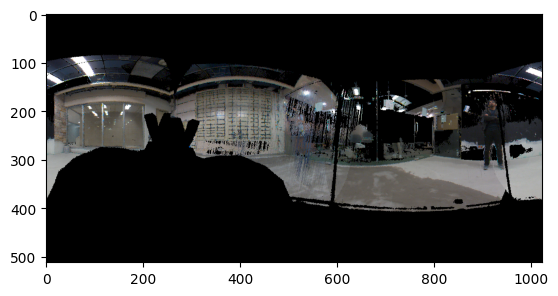

In [4]:
prj_im = project_PCD2ERP(args)
cv2.imwrite('./temp/temp_img.jpg',prj_im)
plt.imshow(prj_im)
plt.show()

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k/upernet_beit-large_fp16_8x1_640x640_160k_ade20k-8fc0dd5d.pth


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.9/dist-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


12/11 07:57:49 - mmengine - WARNING - Failed to search registry with scope "mmseg" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmseg" is a correct scope, or whether the registry is initialized.


Output()

/usr/local/lib/python3.9/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


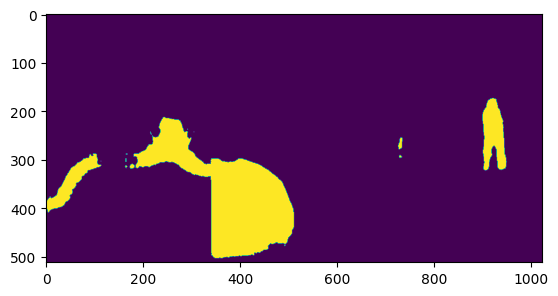

In [5]:
human_mask = segmentation_img('./temp/temp_img.jpg', args)

plt.imshow(human_mask)
plt.show()

In [ ]:
def mask_conversion(mask):
    org_mask = mask
    new_mask = np.zeros(np.shape(org_mask))
    for h in range(len(org_mask)):
        for w in range(len(org_mask[h])):
            if org_mask[h][w] == 0:
                new_mask[h][w] = np.uint8(255)
            else:
                new_mask[h][w] = np.uint8(0)
    # new_mask = new_mask[:,:,np.newaxis]
    new_mask = cv2.merge([new_mask, new_mask, new_mask])
    return new_mask

conversed_mask = mask_conversion(human_mask)
print(np.shape(conversed_mask))
cv2.imwrite('./temp/temp_mask.jpg',conversed_mask)

(512, 1024, 3)


True

In [20]:
prj_im[150,150]

array([24, 24, 24], dtype=uint8)

In [ ]:
inpaint = Inpaint('./temp/temp_img.jpg','./temp/temp_mask.jpg')
inpainted_img = inpaint()
cv2.imwrite('./temp/temp_inpainted.jpg', inpainted_img*255)
plt.imshow(inpainted_img)
plt.show()

# of pixels to be inpainted are 44251: 100%|██████████|44251/44251
